In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)


import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters


from grav_lens import get_datasets
max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



IncrementalPCA(batch_size=64, n_components=64)
Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [2]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm

# Función para reconstruir las imágenes de baja frecuencia a partir de los coeficientes PCA
def reconstruct_lowfreq_from_pca(principal_components, batch_size):
    """
    Reconstruye las imágenes de baja frecuencia a partir de los coeficientes PCA.

    Parámetros:
        principal_components (numpy array): Coeficientes de PCA con shape (batch, n_components).
        batch_size (int): El tamaño del batch.
    
    Retorna:
        lowfreq_images (numpy array): Imágenes de baja frecuencia reconstruidas con shape (batch, 128, 128, 1).
    """
    # Inverso del transformado PCA
    low_freq_vstack = ipca_low.inverse_transform(principal_components)
    
    # Convertir de vstack (batch * 128 * 128) a forma (batch, 128, 128, 1)
    lowfreq_images = low_freq_vstack.reshape(batch_size, 128, 128, 1)
    
    return lowfreq_images

# Función para reconstruir imágenes de alta frecuencia en batch a partir de las gaussianas
def reconstruct_highfreq_from_gmm(gaussians, batch_size, image_shape=(128, 128)):
    """
    Reconstruye las imágenes de alta frecuencia a partir de los parámetros del GMM para todo el batch.

    Parámetros:
        gaussians (numpy array): Parámetros del GMM de shape (batch, n_gaussians, 5).
        batch_size (int): Tamaño del batch.
        image_shape (tuple): La forma de la imagen de salida (ancho, alto), por defecto (128, 128).

    Retorna:
        highfreq_images (numpy array): Imágenes de alta frecuencia reconstruidas con shape (batch, 128, 128, 1).
    """
    highfreq_images = []
    
    for i in range(batch_size):
        # Obtener los parámetros de las gaussianas para esta imagen
        means = gaussians[i, :, :2]
        covariances = np.array([[[g[2]**2, 0], [0, g[3]**2]] for g in gaussians[i]])  # Construir la matriz de covarianzas a partir de std
        weights = gaussians[i, :, 4]

        # Reconstruir la imagen desde los parámetros del GMM
        reconstructed_image = reconstruct_image_from_gmm(image_shape, means, covariances, weights)
        
        # Añadir al batch
        highfreq_images.append(reconstructed_image.reshape(image_shape[0], image_shape[1], 1))  # Añadir canal de color
    
    return np.array(highfreq_images)

# Función para reconstruir el batch completo sumando ambas frecuencias
def reconstruct_batch_images(principal_components, gaussians, batch_size, image_shape=(128, 128)):
    """
    Reconstruye el batch completo de imágenes sumando las componentes de baja y alta frecuencia.

    Parámetros:
        principal_components (numpy array): Coeficientes de PCA de baja frecuencia con shape (batch, n_components).
        gaussians (numpy array): Parámetros del GMM de alta frecuencia de shape (batch, n_gaussians, 5).
        batch_size (int): Tamaño del batch.
        image_shape (tuple): La forma de la imagen de salida (ancho, alto), por defecto (128, 128).

    Retorna:
        batch_images (numpy array): Batch de imágenes reconstruidas con shape (batch, 128, 128, 1).
    """
    # Reconstruir la parte de baja frecuencia
    lowfreq_images = reconstruct_lowfreq_from_pca(principal_components, batch_size)
    
    # Reconstruir la parte de alta frecuencia
    highfreq_images = reconstruct_highfreq_from_gmm(gaussians, batch_size, image_shape)
    
    # Sumar las dos componentes para obtener las imágenes originales
    batch_images = lowfreq_images + highfreq_images
    
    return batch_images


In [3]:
def preprocess_ybatch(y_batch):
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

In [26]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch, 10, 5)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)


(64, 128, 128, 3)
(64, 128, 128, 1)


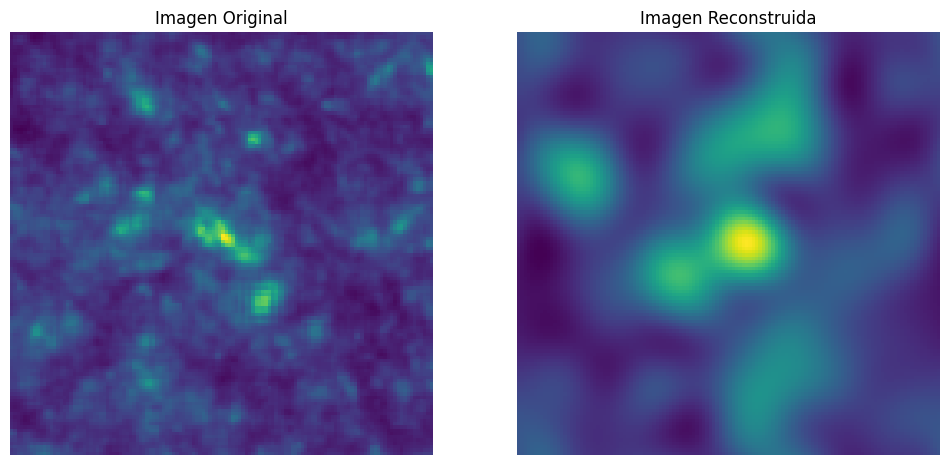

In [30]:
reconstructed_batch = reconstruct_batch_images(principal_components,gaussians,64)

idx = 0
original = y_batch[idx,:,:,0]
reconstructed = low_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

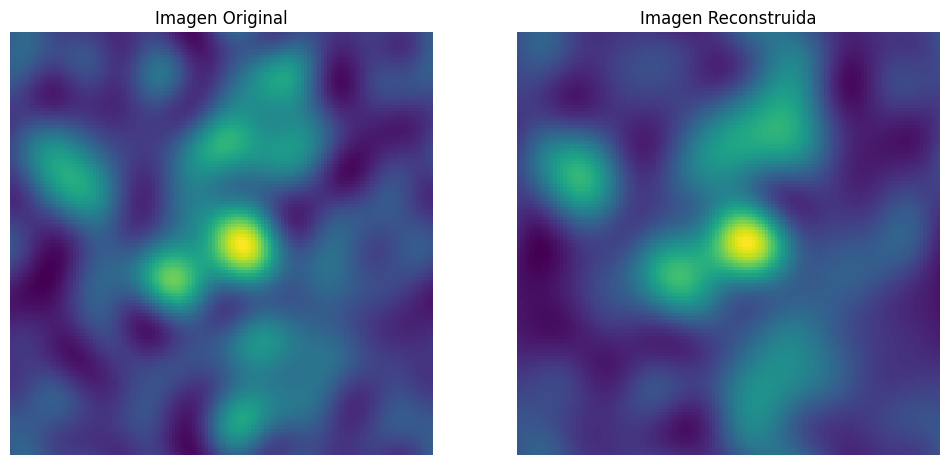

In [10]:
low_recon = reconstruct_lowfreq_from_pca(principal_components, 64)

idx = 0
original = low_batch[idx,:,:,0]
reconstructed = low_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)

In [27]:
mean, std = gp.calculate_image_stats(high_batch)
pos_hb, neg_hb = gp.apply_threshold(high_batch[idx,:,:,0], mean, std, 2)

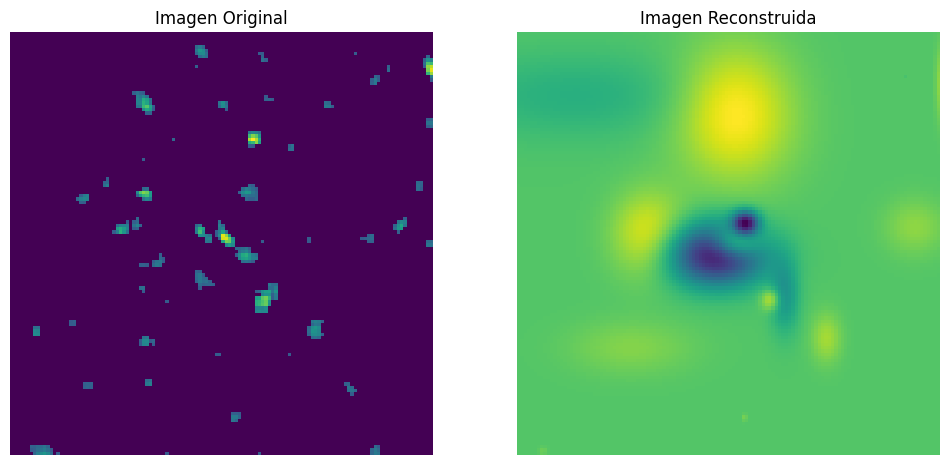

In [31]:
high_recon = reconstruct_highfreq_from_gmm(gaussians, 64)

idx = 0
original = pos_hb
reconstructed = high_recon[idx,:,:,0]
gp.plot_comparison(original, reconstructed)